In [ ]:
import numpy as np
import pandas as pd
import math
import string
import re
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score , confusion_matrix, classification_report

ĐỌC FILE

In [ ]:
### Đọc các file và loại bỏ cột thừa
df_train = pd.read_csv('train.csv', index_col=0)
df_val = pd.read_csv('val.csv', index_col=0)
df_train.drop(columns = ["split"], inplace=True)
df_val.drop(columns = ["split"], inplace=True)

### In ra các dòng đầu tiên của các file
display(df_train.head(5))
display(df_val.head(5))

,Message ID,Subject,Message,Spam/Ham
0,0,christmas tree farm pictures,NaN,ham
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham


,Message ID,Subject,Message,Spam/Ham
23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham
24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham
32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham
37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham
43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham


In [ ]:
### In ra thông tin tổng quát của các bộ dữ liệu
print(df_train.info())
print('------------------------------------------------------------------')
print(df_val.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27284 entries, 0 to 33715
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  27284 non-null  int64 
 1   Subject     27055 non-null  object
 2   Message     26932 non-null  object
 3   Spam/Ham    27284 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB
None
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3084 entries, 23 to 33692
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  3084 non-null   int64 
 1   Subject     3055 non-null   object
 2   Message     3049 non-null   object
 3   Spam/Ham    3084 non-null   object
dtypes: int64(1), object(3)
memory usage: 120.5+ KB
None


TIỀN XỬ LÍ DỮ LIỆU

Ta cần đảm bảo dữ liệu chỉ chứa hai nhãn hợp lệ: “spam” và “ham” và kiểm tra phân bố tần suất của chúng

In [ ]:
### Kiểm tra phân bố tần suất của các giá trị duy nhất trong cột 'Spam/Ham' của DataFrame
print(df_train['Spam/Ham'].value_counts())
print('-----------')
print(df_val['Spam/Ham'].value_counts())

Spam/Ham
spam    13858
ham     13426
Name: count, dtype: int64
-----------
Spam/Ham
spam    1563
ham     1521
Name: count, dtype: int64


Nhận xét: Tần suất phân bố của “spam” và “ham” trên cả tập train và val gần như duy trì ở tỉ lệ 1 : 1 (gần như cân bằng). Đây là điều kiện tốt để huấn luyện mô hình vì không xảy ra mất cân bằng nhãn.

Cần kiểm tra xem có tồn tại NaN không vì nếu tồn tại NaN có thể gây lỗi trong quá trình xây dựng mô hình

In [ ]:
### Kiểm tra số lượng giá trị NaN trong mỗi cột của DataFrame
print(df_train.isnull().sum())
print('-----------')
print(df_val.isnull().sum())

### Một số dòng dữ liệu có cột Message rỗng
df_train[df_train['Message'].isna()]
df_val[df_val['Message'].isna()]

Message ID      0
Subject       229
Message       352
Spam/Ham        0
dtype: int64
-----------
Message ID     0
Subject       29
Message       35
Spam/Ham       0
dtype: int64


,Message ID,Subject,Message,Spam/Ham
1655,1655,revised,NaN,ham
3743,3743,holiday e - cards,NaN,spam
3814,3814,suprise your spouse ! vi [ agra !,NaN,spam
3832,3832,re : no more injections,NaN,spam
4141,4141,NaN,NaN,spam
4429,4429,mortgage interest rates are at their lowest po...,NaN,spam
4683,4683,NaN,NaN,spam
5089,5089,"barnhart sat , 23 jul 2005 05 : 28 : 20 + 0400...",NaN,spam
12188,12188,fyi - piece on enron,NaN,ham
12190,12190,fyi - piece on enron,NaN,ham


Như vậy, ta sẽ xử lý các giá trị NaN bằng cách thay thế bằng chuỗi rỗng

In [ ]:
### Thay thế các giá trị rỗng trong các df bằng chuỗi rỗng ""
df_train.fillna("", inplace=True)
df_val.fillna("", inplace=True)

### Kiểm tra lại
print(df_train.isnull().sum())
print('-----------')
print(df_val.isnull().sum())

Message ID    0
Subject       0
Message       0
Spam/Ham      0
dtype: int64
-----------
Message ID    0
Subject       0
Message       0
Spam/Ham      0
dtype: int64


Ta cần chuyển đổi nhãn phân loại dạng văn bản sang dạng số nhị phân để phù hợp với mô hình

In [ ]:
### Quy đổi spam --> 1, ham --> 0
df_train['Label'] = df_train['Spam/Ham'].map({'spam': 1, 'ham': 0})
df_val['Label'] = df_val['Spam/Ham'].map({'spam': 1, 'ham': 0})

### In lại kiểm tra
display(df_train.head(5))
display(df_val.head(5))

,Message ID,Subject,Message,Spam/Ham,Label
0,0,christmas tree farm pictures,,ham,0
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,0
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,0


,Message ID,Subject,Message,Spam/Ham,Label
23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,0
24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham,0
32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham,0
37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham,0
43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,0


Các dòng trùng lặp có thể gây lặp thông tin, hay có thể làm phức tạp mô hình --> cần loại bỏ

In [ ]:
### Kiểm tra và xử lí các dòng trùng lặp
# Kiểm tra số lượng dòng trước khi xử lý trùng lặp
print("Số lượng dòng trong df_train trước khi xử lý trùng lặp:", len(df_train))
print("Số lượng dòng trong df_val trước khi xử lý trùng lặp:", len(df_val))
# Tìm các dòng trùng lặp
# `duplicated()` trả về một Series boolean, True cho các dòng trùng lặp (giữ lại dòng đầu tiên)
duplicate_rows_train = df_train.duplicated()
duplicate_rows_val = df_val.duplicated()
print("\nSố lượng dòng trùng lặp trong df_train:", duplicate_rows_train.sum())
print("Số lượng dòng trùng lặp trong df_val:", duplicate_rows_val.sum())
# Loại bỏ các dòng trùng lặp
# `drop_duplicates()` loại bỏ các dòng trùng lặp, mặc định giữ lại dòng đầu tiên
df_train.drop_duplicates(inplace=True)
df_val.drop_duplicates(inplace=True)
# Kiểm tra số lượng dòng sau khi xử lý trùng lặp
print("\nSố lượng dòng trong df_train sau khi xử lý trùng lặp:", len(df_train))
print("Số lượng dòng trong df_val sau khi xử lý trùng lặp:", len(df_val))

Số lượng dòng trong df_train trước khi xử lý trùng lặp: 27284
Số lượng dòng trong df_val trước khi xử lý trùng lặp: 3084

Số lượng dòng trùng lặp trong df_train: 0
Số lượng dòng trùng lặp trong df_val: 0

Số lượng dòng trong df_train sau khi xử lý trùng lặp: 27284
Số lượng dòng trong df_val sau khi xử lý trùng lặp: 3084


Nhận xét: Trong các tập dữ liệu train và val đều không có các dòng dữ liệu trùng lặp nhưng vẫn nên có bước tiền xử lí này để có thể áp dụng được cho các tập dữ liệu khác

Cả tiêu đề (Subject) và nội dung (Message) của email đều chứa thông tin quan trọng để phân loại spam hay ham. Ta sẽ thực hiện kết hợp hai trường này thành một trường mới “Content” đặc trưng toàn diện hơn.

In [ ]:
### Kết hợp Subject và Message để tạo nên một đặc trưng duy nhất
df_train['Content'] = df_train['Subject'] + " " + df_train['Message']
df_val['Content'] = df_val['Subject'] + " " + df_val['Message']

### In lại kiểm tra
display(df_train.head(5))
display(df_val.head(5))

,Message ID,Subject,Message,Spam/Ham,Label,Content
0,0,christmas tree farm pictures,,ham,0,christmas tree farm pictures
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0,"vastar resources , inc . gary , production fro..."
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0,calpine daily gas nomination - calpine daily g...
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,0,re : issue fyi - see note below - already done...
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,0,"mcmullen gas for 11 / 99 jackie ,\nsince the i..."


,Message ID,Subject,Message,Spam/Ham,Label,Content
23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,0,miscellaneous - - - - - - - - - - - - - - - - ...
24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham,0,re : purge of old contract _ event _ status fy...
32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham,0,valero 8018 and 1394 it is my understanding th...
37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham,0,01 / 00 natural gas nomination enron methanol ...
43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,0,re : misc . questions - - - - - - - - - - - - ...


Dấu câu và chữ hoa cũng đều có thể làm gia tăng từ vựng và làm phức tạp mô hình, vì thế cũng cần được chuẩn hóa

In [ ]:
### Loại bỏ dấu câu và chuyển đổi sang chữ thường trong tất cả các ký tự trong cột 'Content'
def remove_punctuation(text):
    # Đảm bảo text là chuỗi để tránh lỗi NoneType
    if isinstance(text, str):
        punctuation_free = "".join([i for i in text if i not in string.punctuation])
        return punctuation_free
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Loại bỏ dấu câu
df_train['Content'] = df_train['Content'].apply(lambda x: remove_punctuation(x))
df_val['Content'] = df_val['Content'].apply(lambda x: remove_punctuation(x))
# chuyển đổi tất cả các ký tự trong cột 'Content' thành chữ thường
df_train['Content'] = df_train['Content'].str.lower()
df_val['Content'] = df_val['Content'].str.lower()

URL hay địa chỉ mail thường xuất hiện trong email spam và sự có mặt của nó thường có ý nghĩa lớn hơn nhiều so với nội dung của nó. Vì vậy ta CÓ THỂ thay thế chúng bằng các token chung "URLTOKEN" và "EMAILTOKEN"

In [ ]:
### Thay thế URL/Email bằng token trên cột 'Content'
def replace_urls_emails(text):
    if isinstance(text, str):
        # Thay thế URL bằng token "URLTOKEN"
        text = re.sub(r'http\S+|www\S+|https\S+', 'URLTOKEN', text, flags=re.MULTILINE)
        # Thay thế Email bằng token "EMAILTOKEN"
        text = re.sub(r'\S+@\S+', 'EMAILTOKEN', text)
        return text
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Áp dụng hàm thay thế URL/email cho cột 'Content'
df_train['Content'] = df_train['Content'].apply(lambda x: replace_urls_emails(x))
df_val['Content'] = df_val['Content'].apply(lambda x: replace_urls_emails(x))

Tương tự, sự có mặt của một số hay một chuỗi số thường có ý nghĩa lớn hơn nhiều so với nội dung của nó. Vì vậy ta CÓ THỂ thay thế chúng bằng các token chung 'NUMBERTOKEN'

In [ ]:
# ### Thay thế số bằng token trên cột 'Content'
# def replace_numbers_with_token(text):
#     if isinstance(text, str):
#         # Sử dụng biểu thức chính quy để thay thế các chữ số bằng token "NUMBERTOKEN"
#         return re.sub(r'\d+', 'NUMBERTOKEN', text)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm thay thế số bằng token cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: replace_numbers_with_token(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: replace_numbers_with_token(x))

Tuy nhiên sau khi thử nghiệm có thêm bước tiền xử lý này thì hiệu suất của mô hình (accuracy, precision, recall) đều giảm nên không áp dụng bước tiền xử lí này

Các stopwords như: a, an, the CÓ THỂ không mang quá nhiều ý nghĩa, ta CÓ THỂ loại bỏ chúng

In [ ]:
# ### Loại bỏ stopwords
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# # Lấy danh sách stop words tiếng Anh
# stop_words = set(stopwords.words('english'))
# def remove_stopwords(text):
#     if isinstance(text, str):
#         # Tách văn bản thành các từ
#         words = text.split()
#         # Lọc bỏ stop words
#         filtered_words = [word for word in words if word not in stop_words]
#         # Nối lại các từ thành chuỗi
#         return " ".join(filtered_words)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm loại bỏ stop words cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: remove_stopwords(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: remove_stopwords(x))

Tuy nhiên sau khi thử nghiệm có thêm bước tiền xử lý này thì hiệu suất của mô hình (accuracy, precision, recall) đều giảm nên không áp dụng bước tiền xử lí này

Nhận xét: Ví dụ ta có 'run', 'ran', 'running' đều mang cùng một nghĩa gốc là 'chạy' nhưng lại làm tăng từ điển. Vì vậy CÓ THỂ chúng sẽ làm phức tạp mô hình, làm mô hình kém hiệu quả

In [ ]:
# ### Thực hiện Lemmatization
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.stem import WordNetLemmatizer
# # Tải WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# def lemmatize_text(text):
#     if isinstance(text, str):
#         # Tách văn bản thành các từ
#         words = text.split()
#         # Áp dụng lemmatization cho từng từ
#         # Mặc định lemmatize coi từ là danh từ ('n').
#         # Để chính xác hơn, cần xác định POS tag của từ, nhưng điều này phức tạp hơn.
#         lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#         # Nối lại các từ thành chuỗi
#         return " ".join(lemmatized_words)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm lemmatize_text cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: lemmatize_text(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: lemmatize_text(x))

Tuy nhiên sau khi thử nghiệm có thêm bước tiền xử lý này thì hiệu suất của mô hình (accuracy, precision, recall) đều giảm nên không áp dụng bước tiền xử lí này

Nội dung dữ liệu có thể không phân cách đều với nhau, làm cho việc phân tách từ không chính xác. Vì vậy ta cần chuẩn hóa các khoảng trắng

In [ ]:
### Thực hiện chuẩn hóa khoảng trắng
def remove_extra_whitespace(text):
    if isinstance(text, str):
        # Thay thế 1 hoặc nhiều khoảng trắng liên tiếp bằng 1 khoảng trắng
        text = re.sub(r'\s+', ' ', text)
        # Loại bỏ khoảng trắng ở đầu và cuối chuỗi
        return text.strip()
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Áp dụng hàm chuẩn hóa khoảng trắng cho cột 'Content'
df_train['Content'] = df_train['Content'].apply(lambda x: remove_extra_whitespace(x))
df_val['Content'] = df_val['Content'].apply(lambda x: remove_extra_whitespace(x))

In [ ]:
df_train = pd.read_csv('train.csv', index_col=0)
df_val = pd.read_csv('val.csv', index_col=0)
df_train.drop(columns = ["split"], inplace=True)
df_val.drop(columns = ["split"], inplace=True)

### Thay thế các giá trị rỗng trong các df bằng chuỗi rỗng ""
df_train.fillna("", inplace=True)
df_val.fillna("", inplace=True)

### Quy đổi ham --> 0, spam --> 1
df_train['Label'] = df_train['Spam/Ham'].map({'spam': 1, 'ham': 0})
df_val['Label'] = df_val['Spam/Ham'].map({'spam': 1, 'ham': 0})

### Kiểm tra và xử lí các dòng trùng lặp
# Kiểm tra số lượng dòng trước khi xử lý trùng lặp
print("Số lượng dòng trong df_train trước khi xử lý trùng lặp:", len(df_train))
print("Số lượng dòng trong df_val trước khi xử lý trùng lặp:", len(df_val))
# Tìm các dòng trùng lặp
# `duplicated()` trả về một Series boolean, True cho các dòng trùng lặp (giữ lại dòng đầu tiên)
duplicate_rows_train = df_train.duplicated()
duplicate_rows_val = df_val.duplicated()
print("\nSố lượng dòng trùng lặp trong df_train:", duplicate_rows_train.sum())
print("Số lượng dòng trùng lặp trong df_val:", duplicate_rows_val.sum())
# Loại bỏ các dòng trùng lặp
# `drop_duplicates()` loại bỏ các dòng trùng lặp, mặc định giữ lại dòng đầu tiên
df_train.drop_duplicates(inplace=True)
df_val.drop_duplicates(inplace=True)
# Kiểm tra số lượng dòng sau khi xử lý trùng lặp
print("\nSố lượng dòng trong df_train sau khi xử lý trùng lặp:", len(df_train))
print("Số lượng dòng trong df_val sau khi xử lý trùng lặp:", len(df_val))

### Kết hợp Subject và Message để tạo nên một đặc trưng duy nhất
df_train['Content'] = df_train['Subject'] + " " + df_train['Message']
df_val['Content'] = df_val['Subject'] + " " + df_val['Message']

### Loại bỏ dấu câu và chuyển đổi sang chữ thường trong tất cả các ký tự trong cột 'Content'
def remove_punctuation(text):
    # Đảm bảo text là chuỗi để tránh lỗi NoneType
    if isinstance(text, str):
        punctuation_free = "".join([i for i in text if i not in string.punctuation])
        return punctuation_free
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Loại bỏ dấu câu
df_train['Content'] = df_train['Content'].apply(lambda x: remove_punctuation(x))
df_val['Content'] = df_val['Content'].apply(lambda x: remove_punctuation(x))
# chuyển đổi tất cả các ký tự trong cột 'Content' thành chữ thường
df_train['Content'] = df_train['Content'].str.lower()
df_val['Content'] = df_val['Content'].str.lower()

### Thay thế URL/Email bằng token trên cột 'Content'
def replace_urls_emails(text):
    if isinstance(text, str):
        # Thay thế URL bằng token "URLTOKEN"
        text = re.sub(r'http\S+|www\S+|https\S+', 'URLTOKEN', text, flags=re.MULTILINE)
        # Thay thế Email bằng token "EMAILTOKEN"
        text = re.sub(r'\S+@\S+', 'EMAILTOKEN', text)
        return text
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Áp dụng hàm thay thế URL/email cho cột 'Content'
df_train['Content'] = df_train['Content'].apply(lambda x: replace_urls_emails(x))
df_val['Content'] = df_val['Content'].apply(lambda x: replace_urls_emails(x))

# ### Thay thế số bằng token trên cột 'Content'
# def replace_numbers_with_token(text):
#     if isinstance(text, str):
#         # Sử dụng biểu thức chính quy để thay thế các chữ số bằng token "NUMBERTOKEN"
#         return re.sub(r'\d+', 'NUMBERTOKEN', text)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm thay thế số bằng token cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: replace_numbers_with_token(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: replace_numbers_with_token(x))

# ### Loại bỏ stopwords
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# # Lấy danh sách stop words tiếng Anh
# stop_words = set(stopwords.words('english'))
# def remove_stopwords(text):
#     if isinstance(text, str):
#         # Tách văn bản thành các từ
#         words = text.split()
#         # Lọc bỏ stop words
#         filtered_words = [word for word in words if word not in stop_words]
#         # Nối lại các từ thành chuỗi
#         return " ".join(filtered_words)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm loại bỏ stop words cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: remove_stopwords(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: remove_stopwords(x))

# ### Thực hiện Lemmatization
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.stem import WordNetLemmatizer
# # Tải WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# def lemmatize_text(text):
#     if isinstance(text, str):
#         # Tách văn bản thành các từ
#         words = text.split()
#         # Áp dụng lemmatization cho từng từ
#         # Mặc định lemmatize coi từ là danh từ ('n').
#         # Để chính xác hơn, cần xác định POS tag của từ, nhưng điều này phức tạp hơn.
#         lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#         # Nối lại các từ thành chuỗi
#         return " ".join(lemmatized_words)
#     return text # Trả về giá trị gốc nếu không phải là chuỗi
# # Áp dụng hàm lemmatize_text cho cột 'Content'
# df_train['Content'] = df_train['Content'].apply(lambda x: lemmatize_text(x))
# df_val['Content'] = df_val['Content'].apply(lambda x: lemmatize_text(x))

### Thực hiện chuẩn hóa khoảng trắng
def remove_extra_whitespace(text):
    if isinstance(text, str):
        # Thay thế 1 hoặc nhiều khoảng trắng liên tiếp bằng 1 khoảng trắng
        text = re.sub(r'\s+', ' ', text)
        # Loại bỏ khoảng trắng ở đầu và cuối chuỗi
        return text.strip()
    return text # Trả về giá trị gốc nếu không phải là chuỗi
# Áp dụng hàm chuẩn hóa khoảng trắng cho cột 'Content'
df_train['Content'] = df_train['Content'].apply(lambda x: remove_extra_whitespace(x))
df_val['Content'] = df_val['Content'].apply(lambda x: remove_extra_whitespace(x))

Số lượng dòng trong df_train trước khi xử lý trùng lặp: 27284
Số lượng dòng trong df_val trước khi xử lý trùng lặp: 3084

Số lượng dòng trùng lặp trong df_train: 0
Số lượng dòng trùng lặp trong df_val: 0

Số lượng dòng trong df_train sau khi xử lý trùng lặp: 27284
Số lượng dòng trong df_val sau khi xử lý trùng lặp: 3084


Sau khi test thử có thể khẳng định như sau:
- Thay thế URL/Email bằng token gần như hoàn toàn không làm thay đổi accuracy và precision
- Thay thế số bằng token làm giảm accuracy và precision ở cả tập train và tập val
- Loại bỏ stopwords làm giảm accuracy và precision ở cả tập train và tập val
- Thực hiện Lemmatization làm giảm accuracy và precision ở cả tập train và tập val
- Thực hiện chuẩn hóa khoảng trắng gần như hoàn toàn không làm thay đổi accuracy và precision


--> Cần test với:
- Thay thế URL/Email bằng token
- Thực hiện chuẩn hóa khoảng trắng

In [ ]:
### Lưu df_train và df_val sau khi tiền xử lý vào các tệp CSV
df_train.to_csv('df_train_processed.csv', index=False)
df_val.to_csv('df_val_processed.csv', index=False)


MÔ HÌNH PHÂN LOẠI EMAIL SPAM

In [ ]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_probs = {}
        self.word_probs = {}
        self.vocabulary = set()
        self.total_words_in_class = {}

    def fit(self, X, y):

        total_docs = len(y)
        class_counts = Counter(y)
        for cls, count in class_counts.items():
            self.class_probs[cls] = count / total_docs

        docs_by_class = {}
        for i, doc in enumerate(X):
            label = y[i]
            if label not in docs_by_class:
                docs_by_class[label] = []
            docs_by_class[label].append(str(doc))

        word_counts_by_class = {}
        for cls, docs in docs_by_class.items():
            all_words_in_class = " ".join(docs).split()
            word_counts_by_class[cls] = Counter(all_words_in_class)
            self.vocabulary.update(word_counts_by_class[cls].keys())
            self.total_words_in_class[cls] = sum(word_counts_by_class[cls].values())

        for cls, word_counts in word_counts_by_class.items():
            total_words = self.total_words_in_class[cls]
            vocab_size = len(self.vocabulary)
            self.word_probs[cls] = {}

            for word, count in word_counts.items():
                self.word_probs[cls][word] = (count + self.alpha) / (total_words + vocab_size * self.alpha)

            for word in self.vocabulary:
                 if word not in self.word_probs[cls]:
                    self.word_probs[cls][word] = (0 + self.alpha) / (total_words + vocab_size * self.alpha)


    def predict(self, X):

        predictions = []
        vocab_size = len(self.vocabulary)

        for doc in X:
            scores = {}
            words = str(doc).split()

            for cls in self.class_probs:
                scores[cls] = math.log(self.class_probs[cls])
                total_words_cls = self.total_words_in_class.get(cls, 0)

                for word in words:
                    word_prob = self.word_probs[cls].get(word, (0 + self.alpha) / (total_words_cls + vocab_size * self.alpha))

                    if word_prob > 0:
                         scores[cls] += math.log(word_prob)
                    else:
                        scores[cls] += math.log(1e-10)

            predicted_class = max(scores, key=scores.get)
            predictions.append(predicted_class)
        return predictions

    def score(self, X, y):

        predictions = self.predict(X)
        correct_predictions = sum([1 for i in range(len(y)) if predictions[i] == y[i]])
        return correct_predictions / len(y)


Training with alpha = 0
  Train - Accuracy: 0.9965, Precision: 0.9962, Recall: 0.9970
  Validation - Accuracy: 0.9903, Precision: 0.9910, Recall: 0.9898
Training with alpha = 0.05
  Train - Accuracy: 0.9952, Precision: 0.9945, Recall: 0.9962
  Validation - Accuracy: 0.9899, Precision: 0.9891, Recall: 0.9910
Training with alpha = 0.1
  Train - Accuracy: 0.9948, Precision: 0.9939, Recall: 0.9958
  Validation - Accuracy: 0.9899, Precision: 0.9891, Recall: 0.9910
Training with alpha = 0.15
  Train - Accuracy: 0.9945, Precision: 0.9936, Recall: 0.9955
  Validation - Accuracy: 0.9899, Precision: 0.9891, Recall: 0.9910
Training with alpha = 0.2
  Train - Accuracy: 0.9943, Precision: 0.9934, Recall: 0.9953
  Validation - Accuracy: 0.9899, Precision: 0.9891, Recall: 0.9910
Training with alpha = 0.25
  Train - Accuracy: 0.9942, Precision: 0.9934, Recall: 0.9953
  Validation - Accuracy: 0.9899, Precision: 0.9891, Recall: 0.9910
Training with alpha = 0.3
  Train - Accuracy: 0.9942, Precision: 0.99

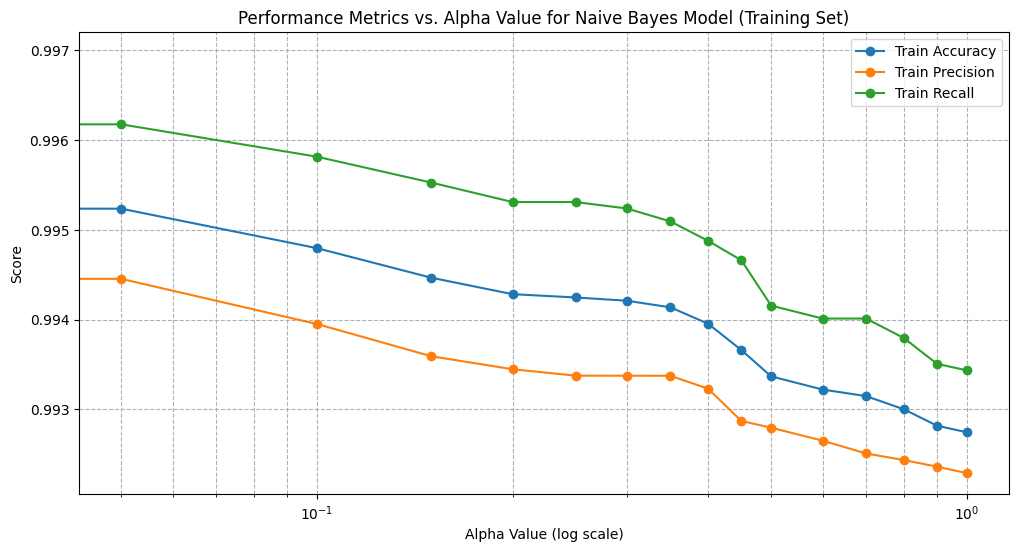

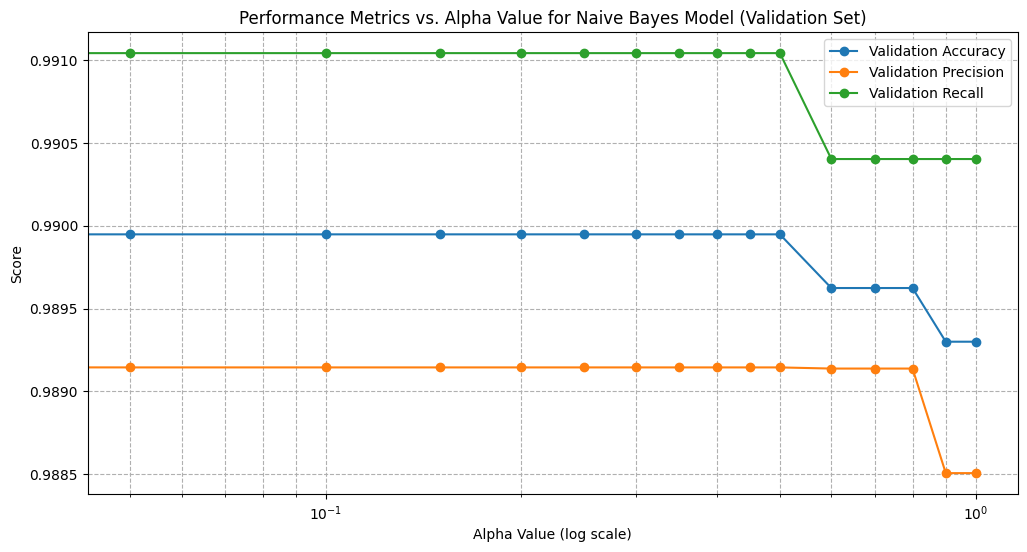

In [ ]:
# Danh sách các giá trị alpha để test
alpha_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Các biến lưu các giá trị tính hiệu suất
accuracy_scores_train = {}
precision_scores_train = {}
recall_scores_train = {}
accuracy_scores_val = {}
precision_scores_val = {}
recall_scores_val = {}

for alpha in alpha_values:
    print(f"Training with alpha = {alpha}")

    # Khởi tạo mô hình
    nb_model = NaiveBayes(alpha=alpha)

    # Huấn luyện mô hình
    nb_model.fit(df_train['Content'].tolist(), df_train['Label'].tolist())

    # Dự đoán cho tập train
    nb_predictions_train = nb_model.predict(df_train['Content'].tolist())
    actual_labels_train = df_train['Label'].tolist()

    # Tính hiệu suất cho tập train
    accuracy_train = accuracy_score(actual_labels_train, nb_predictions_train)
    precision_train = precision_score(actual_labels_train, nb_predictions_train)
    recall_train = recall_score(actual_labels_train, nb_predictions_train)

    # Lưu hiệu suất tập train
    accuracy_scores_train[alpha] = accuracy_train
    precision_scores_train[alpha] = precision_train
    recall_scores_train[alpha] = recall_train

    # Dự đoán cho tập val
    nb_predictions_val = nb_model.predict(df_val['Content'].tolist())
    actual_labels_val = df_val['Label'].tolist()

    # Tính hiệu suất cho tập val
    accuracy_val = accuracy_score(actual_labels_val, nb_predictions_val)
    precision_val = precision_score(actual_labels_val, nb_predictions_val)
    recall_val = recall_score(actual_labels_val, nb_predictions_val)

    # Lưu hiệu suất tập val
    accuracy_scores_val[alpha] = accuracy_val
    precision_scores_val[alpha] = precision_val
    recall_scores_val[alpha] = recall_val

    print(f"  Train - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}")
    print(f"  Validation - Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}")

### Vẽ đồ thị
alphas = list(accuracy_scores_val.keys())
accuracies_train = list(accuracy_scores_train.values())
precisions_train = list(precision_scores_train.values())
recalls_train = list(recall_scores_train.values())
accuracies_val = list(accuracy_scores_val.values())
precisions_val = list(precision_scores_val.values())
recalls_val = list(recall_scores_val.values())
# Đồ thị tập train
plt.figure(figsize=(12, 6))
plt.plot(alphas, accuracies_train, marker='o', linestyle='-', label='Train Accuracy')
plt.plot(alphas, precisions_train, marker='o', linestyle='-', label='Train Precision')
plt.plot(alphas, recalls_train, marker='o', linestyle='-', label='Train Recall')
plt.xscale('log')
plt.xlabel('Alpha Value (log scale)')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Alpha Value for Naive Bayes Model (Training Set)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
# Đồ thị tập val
plt.figure(figsize=(12, 6))
plt.plot(alphas, accuracies_val, marker='o', linestyle='-', label='Validation Accuracy')
plt.plot(alphas, precisions_val, marker='o', linestyle='-', label='Validation Precision')
plt.plot(alphas, recalls_val, marker='o', linestyle='-', label='Validation Recall')
plt.xscale('log')
plt.xlabel('Alpha Value (log scale)')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Alpha Value for Naive Bayes Model (Validation Set)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

Nhận xét: alpha càng cao thì hiệu suất càng giảm. Tuy nhiên alpha càng gần 0 thì hiệu suất ở tập val gần như không đổi, trong khi đó hiệu suất ở tập train cũng tăng "rất ít". Thêm vào đó ta nên lấy alpha > 0 (lí do được viết trong report) nên dựa vào kết quả đã test, ta chọn alpha = 0.05

THỬ NGHIỆM THỰC TẾ

Test thử một email tự nhập

In [ ]:
### gom các bước tiền xử lí thành một hàm cho tiện xử lí
def preprocess_data(df_train, df_val):

    df_train.fillna("", inplace=True)
    df_val.fillna("", inplace=True)

    df_train['Label'] = df_train['Spam/Ham'].map({'spam': 1, 'ham': 0})
    df_val['Label'] = df_val['Spam/Ham'].map({'spam': 1, 'ham': 0})

    duplicate_rows_train = df_train.duplicated()
    duplicate_rows_val = df_val.duplicated()

    df_train.drop_duplicates(inplace=True)
    df_val.drop_duplicates(inplace=True)

    df_train['Content'] = df_train['Subject'] + " " + df_train['Message']
    df_val['Content'] = df_val['Subject'] + " " + df_val['Message']

    def remove_punctuation(text):
        if isinstance(text, str):
            punctuation_free = "".join([i for i in text if i not in string.punctuation])
            return punctuation_free
        return text
    df_train['Content'] = df_train['Content'].apply(lambda x: remove_punctuation(x))
    df_val['Content'] = df_val['Content'].apply(lambda x: remove_punctuation(x))
    df_train['Content'] = df_train['Content'].str.lower()
    df_val['Content'] = df_val['Content'].str.lower()

    def replace_urls_emails(text):
        if isinstance(text, str):
            text = re.sub(r'http\S+|www\S+|https\S+', 'URLTOKEN', text, flags=re.MULTILINE)
            text = re.sub(r'\S+@\S+', 'EMAILTOKEN', text)
            return text
        return text
    df_train['Content'] = df_train['Content'].apply(lambda x: replace_urls_emails(x))
    df_val['Content'] = df_val['Content'].apply(lambda x: replace_urls_emails(x))

    def remove_extra_whitespace(text):
        if isinstance(text, str):
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
        return text
    df_train['Content'] = df_train['Content'].apply(lambda x: remove_extra_whitespace(x))
    df_val['Content'] = df_val['Content'].apply(lambda x: remove_extra_whitespace(x))

    return df_train, df_val

nb_model = NaiveBayes(alpha=0.05)

# Huấn luyện mô hình
nb_model.fit(df_train['Content'].tolist(), df_train['Label'].tolist())

subject = input("Nhập tiêu đề email (Subject): ")
message = input("Nhập nội dung email (Message): ")

# Tạo DataFrame tạm thời với cấu trúc Subject, Message, Spam/Ham (preprocess_data sẽ xử lý việc kết hợp Subject và Message thành Content)
email_df = pd.DataFrame({'Subject': [subject], 'Message': [message], 'Spam/Ham': ['ham']})
dummy_df = pd.DataFrame(columns=['Subject', 'Message', 'Spam/Ham']) # Dummy df for preprocess_data

# Áp dụng tiền xử lý
processed_email_df, _ = preprocess_data(email_df, dummy_df)

# Lấy nội dung đã tiền xử lý từ cột 'Content'
processed_email_content = processed_email_df['Content'].tolist()

# Dự đoán sử dụng mô hình đã huấn luyện
prediction = nb_model.predict(processed_email_content)

# In kết quả dự đoán
if prediction[0] == 1:
    print("Kết quả dự đoán: SPAM")
else:
    print("Kết quả dự đoán: HAM")

Nhập tiêu đề email (Subject): New Book Club Title - April
Nhập nội dung email (Message): This month we’ll be reading 'The Midnight Library'. First meeting: April 3rd, 6PM.
Kết quả dự đoán: HAM


Test thử một file csv khác

In [ ]:
def evaluate_on_a_file(model, csv_path):

    try:

        df = pd.read_csv(csv_path, index_col=0)
        if 'split' in df.columns:
            df.drop(columns=["split"], inplace=True)
        if 'split' in df_val.columns:
            df.drop(columns=["split"], inplace=True)

        # Tiền xử lí
        df_eval_processed, _ = preprocess_data(df, pd.DataFrame(columns=df.columns))
        df_eval_processed['Content'] = df_eval_processed['Content'].astype(str)
        actual_labels_eval = df_eval_processed['Label'].tolist()

        # Dự đoán
        nb_predictions_eval = model.predict(df_eval_processed['Content'].tolist())

        # Tính hiệu suất
        print(f"\nĐánh giá hiệu suất trên tập {csv_path}:")
        print("Accuracy:", accuracy_score(actual_labels_eval, nb_predictions_eval))
        print("Precision:", precision_score(actual_labels_eval, nb_predictions_eval))
        print("Recall:", recall_score(actual_labels_eval, nb_predictions_eval))
        print("Confusion Matrix:\n", confusion_matrix(actual_labels_eval, nb_predictions_eval))
        print("Classification Report:\n", classification_report(actual_labels_eval, nb_predictions_eval))

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{csv_path}'.")
    except Exception as e:
        print(f"Đã xảy ra lỗi khi xử lý file '{csv_path}': {e}")

### Tạo một file csv khác để thử chương 4
emails = [
    # spam emails
    {
        "Subject": "Get Paid To Work From Home",
        "Message": "Are you tired of your 9-to-5 job? Join thousands of people who earn over $500 a day from home. No experience required. Click here to get started: www.workfastnow.com",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Claim Your Free Gift Card Today",
        "Message": "Congratulations! You have been selected to receive a $1000 Walmart gift card. Complete the survey to claim your prize.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "New Weight Loss Secret Doctors Won’t Tell You",
        "Message": "Lose 10kg in two weeks with this Japanese tonic. Proven by thousands. Learn the truth now.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Your Mortgage Pre-Approval Expires Soon",
        "Message": "Rates are at historic lows! Lock in 2.3% APR. Apply now.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Eliminate All Debt Legally",
        "Message": "Government program to erase your credit card and student loan debt. No fees, no checks. Start today.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Protect Your Identity Online",
        "Message": "Get our identity protection service free for 30 days and stay safe from hackers.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Increase Your Manhood",
        "Message": "Boost your performance naturally. Discreet shipping. Guaranteed results.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Act Now – You’ve Been Selected!",
        "Message": "One of 50 people to receive this investment opportunity. No risk. High return.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Earn Bitcoin Daily",
        "Message": "Our system helps you earn Bitcoin passively. No tech knowledge required.",
        "Spam/Ham": "spam"
    },
    {
        "Subject": "Save Big On Insurance",
        "Message": "Compare car insurance quotes and save $700/year. Enter zip code.",
        "Spam/Ham": "spam"
    },
    # ham emails
    {
        "Subject": "Final Notice - Pay Your Invoice",
        "Message": "Your payment is past due. Services will be terminated if unpaid. Pay now.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Your iCloud Account Is Locked",
        "Message": "Suspicious activity detected. Sign in to restore account.",
        "Spam/Ham": "ham"
    },

    {
        "Subject": "Quarterly Project Update",
        "Message": "Attached is the Q2 update with metrics and blockers. Let's schedule a review next week.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "IT Support Request - Laptop Issue",
        "Message": "My laptop is overheating and shutting down. Can IT take a look?",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Final Exam Schedule",
        "Message": "Final exam for MTH56-2425 is Tuesday, 9:00 AM, Room 405. Review material uploaded Friday.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Monthly Newsletter – November",
        "Message": "Welcome to the November newsletter! Highlights include student work and upcoming events.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Reimbursement for Conference Travel",
        "Message": "I’ve attached all receipts and forms for AI Conference reimbursement.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Dinner this weekend?",
        "Message": "Are you free Saturday night? Thought we could try the new Italian place near the park.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Library Book Due Reminder",
        "Message": "Just a heads-up: your books are due back on March 31st. Renew online if needed.",
        "Spam/Ham": "ham"
    },
    {
        "Subject": "Cousin’s Wedding Invite",
        "Message": "You’re invited to Emily’s wedding on May 20th at River Gardens. Formal invite to follow.",
        "Spam/Ham": "ham"
    }
]

df_emails = pd.DataFrame(emails)
df_emails.to_csv("sample_emails_for_testing.csv")

### áp dụng
nb_model = NaiveBayes(alpha=0.05)
# Huấn luyện mô hình
nb_model.fit(df_train['Content'].tolist(), df_train['Label'].tolist())
# sử dụng hàm
testfile = "sample_emails_for_testing.csv"
evaluate_on_a_file(nb_model, testfile)



Đánh giá hiệu suất trên tập sample_emails_for_testing.csv:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix:
 [[10  0]
 [ 0 10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



(Nhận xét: Vì tập test thử chỉ có 10 email spam và 10 email không phải spam và các email test thử không khó để phân loại nên việc phân loại cho ra kết quả tuyệt đối)